In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Lets make a little toy model

In [2]:
def match_surrogates0(theta, intrinsic_noise, Groups=4, f=0):
    ## Different split approach
    from sklearn.cluster import AgglomerativeClustering
    sorted_args = np.argsort(theta)
    theta = theta[sorted_args]
    intrinsic_noise=intrinsic_noise[sorted_args]
    clustering = AgglomerativeClustering(Groups).fit(theta.reshape(-1,1))
    labels = sorted(clustering.labels_)
    unique_ls, counts = np.unique(labels, return_counts=True)
    theta_R = np.concatenate([[np.mean(theta[labels==i])]*c for i, c in zip(unique_ls, counts)])
    noises = np.concatenate([intrinsic_noise[labels==i] for i, c in zip(unique_ls, counts)])
    surrogate_raw = get_Q(theta_R)
    surrogate_data = surrogate_raw + noises*(1-f) + f*np.random.normal(0, sigma_epsilon, len(theta_R)) 
    return theta_R, surrogate_data, surrogate_raw

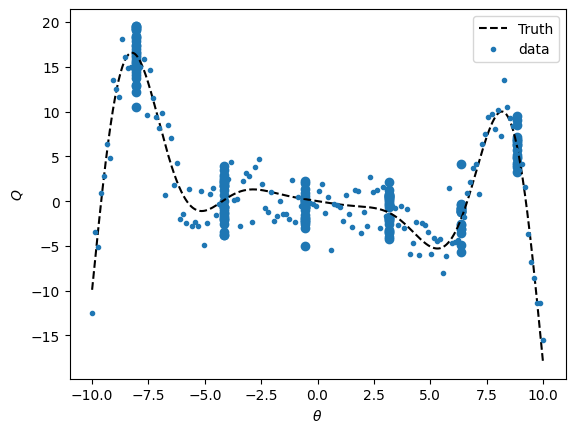

In [12]:
sigma_epsilon = 2 # jitter ontop of smooth variation
N=150            # Number of data samples
Domain = [-10,10] # Domain of parameters
LR = 3e-3         # Optimization learning rate 
ITERS = 3000      # max iteration
epsilon = 0.0     # Difference in smoothness from surrogates to high res
# Toy Models
def get_Q(theta, A=-0.4, B=0.4):
    """
    This is the model which we ultimitely want to predict, represents the 
    smooth variation on some function. 
    """
    return A * theta  +  theta**3*B**4 * np.sin(theta) #+ C * x * theta + D * x

def get_R(theta, epsilon=epsilon, A=-0.4, B=0.4):
    """
    If Surrogates have some different mean function then you can make that 
    here. For simulations of same "resolution" this should return the same
    as Q
    """
    Q = get_Q(theta, A, B)
    delta = epsilon * theta  + epsilon*1/(theta**2+ epsilon)
    return Q + delta

# underlying truth: 
theta=np.linspace(*np.array(Domain)+0.001, 1001, endpoint=True)
Y = get_Q(theta) 
plt.plot(theta, Y, 'k--', label='Truth')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$T$')

# Sample Data
np.random.seed(194)
theta_Q = np.linspace(Domain[0], Domain[1], N, )
# theta_Q = np.random.uniform(Domain[0], Domain[1], N)
a = np.argsort(theta_Q)
theta_Q=theta_Q[a]
Q_raw = get_Q(theta_Q)

def model_data(theta, noise=None):
    Q = get_Q(theta)
    if noise is not None:
        return Q + noise
    noise = np.random.normal(0, sigma_epsilon, len(theta))
    return Q+noise, noise


# Sample Data
np.random.seed(193)
theta_Q2 = np.random.uniform(Domain[0]+0.01, Domain[1]-0.01, N)
a2 = np.argsort(theta_Q2)
theta_Q2=theta_Q2[a]
Q2_raw = get_Q(theta_Q2)
Q2 = np.random.normal(Q2_raw, sigma_epsilon,N)



np.random.seed(30)
Q = np.random.normal(Q_raw, sigma_epsilon,N)
intrinsic_noise = Q - Q_raw
intrinsic_noise2 = Q2 - Q2_raw


plt.plot(theta_Q, Q, '.', label='data')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$Q$')
plt.legend()

div = 2
N_R = int(N/div)
f=0.00

theta_R, R, E = match_surrogates0(theta_Q, intrinsic_noise, Groups=6, f=0)

plt.scatter(theta_R, R)


# Now we can use CARPoolGP

In [4]:
from src import CARPoolSimulations

# Create simulation objects and surrogate objects
sims = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters = theta_Q; sims.quantities=Q
surrs.parameters = theta_R; surrs.quantities=R

In [5]:
from src import CARPoolEmulator

#Build an emulator 
emu = CARPoolEmulator.Emulator(sims, surrs)

#Initialize some set of parameters (or default)
params = {"log_scaleV":0.1,
          "log_ampV":1.0,
          "log_scaleW":1.0,
          "log_ampW":1.0,
          "log_scaleX":0.0,
          "log_ampX":0.0,                
          "log_scaleM":0.0,
          "log_ampM":0.0,
          "log_deltaP":0.0,
          "log_jitterV":1.0,
          "log_jitterW":1.0,
          "log_mean":0.0}

# Train the emulator
emu.train(params, learning_rate=1e-3, max_iterations=1000)

# now emulate! 
pred_mean, pred_var = emu.predict(theta)

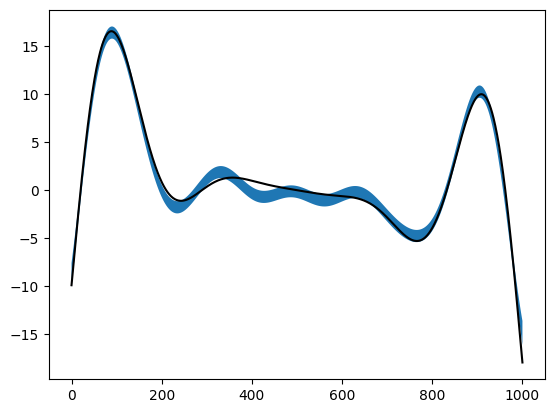

In [6]:

std = np.sqrt(np.diag(pred_var))
plt.fill_between(np.arange(1001), pred_mean - std, pred_mean+std)
plt.plot(Y, 'k')


# Active learning approach

In [7]:
from src import CARPoolEmulator

# Generate an active learning model
model = CARPoolEmulator.ActiveLearning(sims, surrs, theta, Domain[0], Domain[1])

# Initialize the training
best_params = model.train(learning_rate=1e-3, max_iterations=100)

In [9]:
# Run an active learning step to find the next state (Ngrid is for 2**N)
next_thetas, next_surrogates = model.active_learning_step(num_new=6, Ngrid=5)

(array([ 9.95911779,  6.35680264,  3.10482068, -9.85819802, -0.50163751,
         9.07310089]),
 array([ 8.8590604 ,  6.37583893,  3.15436242, -8.05369128, -0.53691275,
         8.8590604 ]))

In practice we would now run simulations at these new points, but lets say we have a model that is the simulation. then we can update the simulations and re train

next_data, noise = model_data(next_thetas)
next_surrogate_data = model_data(next_surrogates)[0]
